In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def preprocess_barcode(image):
    # Step 1: Denoise the image using Gaussian blur
    denoised = cv2.GaussianBlur(image, (5, 5), 0)

    # Step 2: Binarize the image (convert to black and white)
    _, binary = cv2.threshold(denoised, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Step 3: Detect edges using Sobel filter
    sobelx = cv2.Sobel(binary, cv2.CV_64F, 1, 0, ksize=3)
    sobelx = cv2.convertScaleAbs(sobelx)

    # Step 4: Close gaps in the bars using morphological closing
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
    closed = cv2.morphologyEx(sobelx, cv2.MORPH_CLOSE, kernel)

    # Step 5: Find contours and crop the barcode region
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        cropped = binary[y:y + h, x:x + w]
    else:
        cropped = binary  

    return binary, closed, cropped


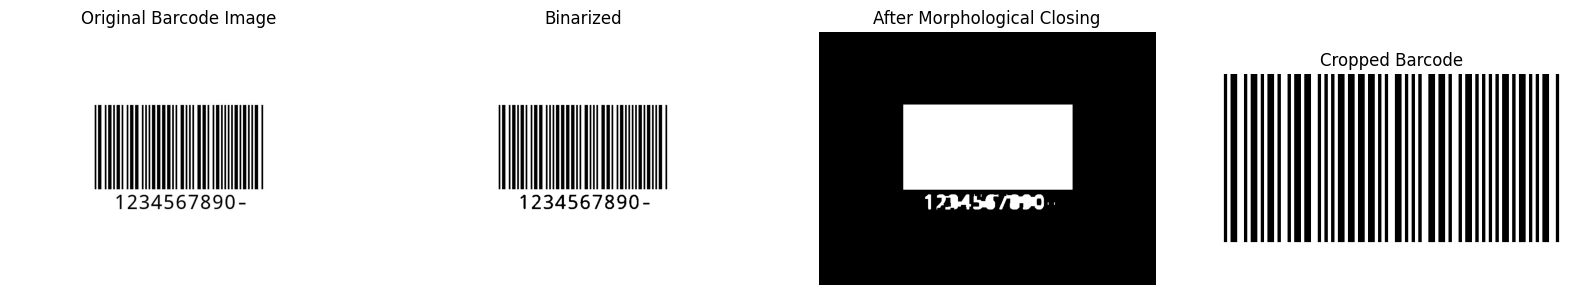

In [6]:
image_path = "Test Cases\\01 - lol easy.jpg"  
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

binary, closed, cropped = preprocess_barcode(image)


plt.figure(figsize=(20, 5))  

# Original Image
plt.subplot(1, 4, 1)  
plt.imshow(image, cmap='gray')
plt.title("Original Barcode Image")
plt.axis("off")

# Binarized Image
plt.subplot(1, 4, 2)  
plt.imshow(binary, cmap='gray')
plt.title("Binarized")
plt.axis("off")

# Morphologically Closed Image
plt.subplot(1, 4, 3) 
plt.imshow(closed, cmap='gray')
plt.title("After Morphological Closing")
plt.axis("off")

# Cropped Barcode
plt.subplot(1, 4, 4) 
plt.imshow(cropped, cmap='gray')
plt.title("Cropped Barcode")
plt.axis("off")


plt.show()